In [2]:
import os
from dotenv import load_dotenv
import mlflow

# Load environment variables from .env file
load_dotenv()
print(os.getenv('AWS-MLFLOW'))
# Get the AWS MLflow URI from .env file
aws_mlflow_uri = os.getenv('AWS-MLFLOW')

mlflow.set_tracking_uri(aws_mlflow_uri)

with mlflow.start_run():
    mlflow.log_param("param1", 15)
    mlflow.log_metric("metric1", 0.89)

http://ec2-54-210-190-31.compute-1.amazonaws.com:5000/
🏃 View run skillful-bug-635 at: http://ec2-54-210-190-31.compute-1.amazonaws.com:5000/#/experiments/0/runs/a8a6dd08f982410bbffc030fce91ed6b
🧪 View experiment at: http://ec2-54-210-190-31.compute-1.amazonaws.com:5000/#/experiments/0
🏃 View run skillful-bug-635 at: http://ec2-54-210-190-31.compute-1.amazonaws.com:5000/#/experiments/0/runs/a8a6dd08f982410bbffc030fce91ed6b
🧪 View experiment at: http://ec2-54-210-190-31.compute-1.amazonaws.com:5000/#/experiments/0


In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('data/reddit.csv')
data.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [3]:
data.dropna(inplace=True)
data = data[~(data['clean_comment'].str.strip() == '')]

In [4]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [5]:
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Arif\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Arif\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
def preprocess_comment(comment):
    comment = comment.lower()

    comment = comment.strip()

    comment = re.sub(r'\n', ' ', comment)

    comment = re.sub(r'[^A-Za-z0-9\s!?.,]', '', comment)

    stop_words = set(stopwords.words('english')) - {'not', 'but', 'however', 'no', 'yet'}
    comment = ' '.join([word for word in comment.split() if word not in stop_words])

    lemmatizer = WordNetLemmatizer()
    comment = ' '.join([lemmatizer.lemmatize(word) for word in comment.split()])

    return comment

In [9]:
data['clean_comment'] = data['clean_comment'].apply(preprocess_comment)

In [10]:
data.head()

,clean_comment,category
0,family mormon never tried explain still stare ...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal not wr...,0
4,benefit may want read living buddha living chr...,1


In [11]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
vectorizer = CountVectorizer(max_features=10000)

In [13]:
X = vectorizer.fit_transform(data['clean_comment']).toarray()
y = data['category']

In [14]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(37028, 10000))

In [15]:
X.shape

(37028, 10000)

In [16]:
y.shape

(37028,)

In [17]:
mlflow.set_experiment('RF Baseline')

2025/07/04 22:40:43 INFO mlflow.tracking.fluent: Experiment with name 'RF Baseline' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///d:/repos/YoutubeViewerSentiment/mlruns/213444493593505903', creation_time=1751658043933, experiment_id='213444493593505903', last_update_time=1751658043933, lifecycle_stage='active', name='RF Baseline', tags={}>

2025/07/04 22:49:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/04 22:49:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Accuracy: 0.6505536051849852


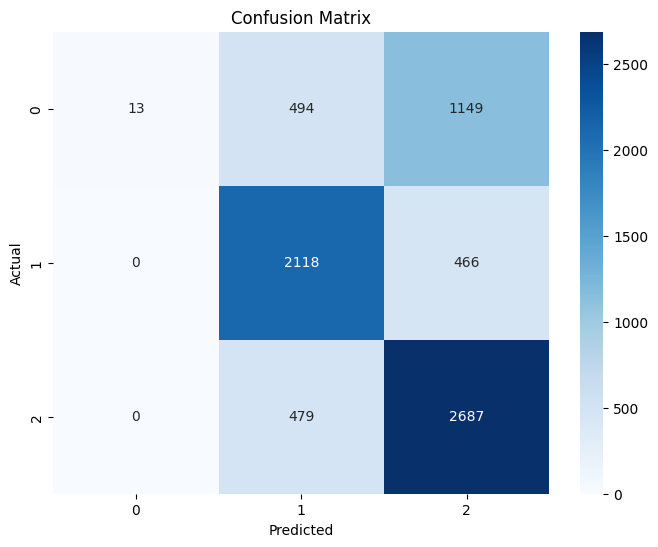

In [22]:
import mlflow.sklearn


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

with mlflow.start_run() as run:
    mlflow.set_tag('mlflow.runName', 'RandomForest_BaseLine_TrainTestSplit')
    mlflow.set_tag('experiment_type', 'baseline')
    mlflow.set_tag('model_type', 'RandomForestClassifier')

    mlflow.set_tag('description', 'Baseline RandomForest model for sentiment analysis using BoW')

    mlflow.log_param('vectorizer_type', 'CountVectorizer')
    mlflow.log_param('vectorizer_max_features', vectorizer.max_features)

    n_estimators = 200
    max_depth = 15

    mlflow.log_param('n_estimator', n_estimators)
    mlflow.log_param('max_depth', max_depth)

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    mlflow.log_metric('accuracy', accuracy)

    classification_rep = classification_report(y_test, y_pred, output_dict=True)

    for label, metrics in classification_rep.items():
        if isinstance(metrics, dict):
            for metric, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric}", value)

    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

    mlflow.sklearn.log_model(model, 'random_forest_model')

    data.to_csv('dataset.csv', index = False)
    mlflow.log_artifact('dataset.csv')

print(f"Accuracy: {accuracy}")


In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       1.00      0.01      0.02      1656
           0       0.69      0.82      0.75      2584
           1       0.62      0.85      0.72      3166

    accuracy                           0.65      7406
   macro avg       0.77      0.56      0.49      7406
weighted avg       0.73      0.65      0.57      7406



In [29]:
data.to_csv('reddit_preprocessed.csv', index=False)

In [30]:
pd.read_csv('reddit_preprocessed.csv').head()


,clean_comment,category
0,family mormon never tried explain still stare ...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal not wr...,0
4,benefit may want read living buddha living chr...,1
